In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

# Setup input pipeline
The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.

Download the dataset using TFDS.

In [24]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                         as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

In [25]:
#The dataset info includes the encoder (a tfds.features.text.SubwordTextEncoder).
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.



In [26]:
sample_string = 'Hello Tensorflow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

assert original_string == sample_string


Encoded string is [4025, 222, 6307, 2327, 2934, 7975]
The original string: "Hello Tensorflow."


In [27]:
for index in encoded_string:
    print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
2934 ----> flow
7975 ----> .


# Prepare the data for training
Next create batches of these encoded strings. Use the padded_batch method to zero-pad the sequences to the length of the longest string in the batch:

In [28]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32

In [29]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, padded_shapes=([None,],()))




In [30]:
test_dataset = test_dataset.padded_batch(BATCH_SIZE, padded_shapes=([None,],()))


# Create the model
Build a tf.keras.Sequential model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [32]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(1e-4),
             metrics=['accuracy'])

In [33]:
history = model.fit(train_dataset,epochs=10,
                   validation_data=test_dataset,
                   validation_steps=30)

Epoch 1/10
782/782 [==============================] - 1011s 1s/step - loss: 0.5539 - accuracy: 0.6674 - val_loss: 0.4077 - val_accuracy: 0.8094
Epoch 2/10
782/782 [==============================] - 971s 1s/step - loss: 0.3076 - accuracy: 0.8731 - val_loss: 0.3556 - val_accuracy: 0.8521
Epoch 3/10
782/782 [==============================] - 1094s 1s/step - loss: 0.2312 - accuracy: 0.9115 - val_loss: 0.3765 - val_accuracy: 0.8542
Epoch 4/10
782/782 [==============================] - 988s 1s/step - loss: 0.1937 - accuracy: 0.9289 - val_loss: 0.3785 - val_accuracy: 0.8708
Epoch 5/10
782/782 [==============================] - 999s 1s/step - loss: 0.1725 - accuracy: 0.9378 - val_loss: 0.3827 - val_accuracy: 0.8646
Epoch 6/10
782/782 [==============================] - 940s 1s/step - loss: 0.1600 - accuracy: 0.9435 - val_loss: 0.4342 - val_accuracy: 0.8531
Epoch 7/10
782/782 [==============================] - 953s 1s/step - loss: 0.1398 - accuracy: 0.9516 - val_loss: 0.4340 - val_accuracy: 0.84

In [34]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    782/Unknown - 149s 190ms/step - loss: 0.4631 - accuracy: 0.8534Test Loss: 0.46309062632043724
Test Accuracy: 0.8533599972724915


The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would use masking to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [35]:
def pad_to_size(vec,size):
    zeros = [] * (size - len(vec))
    vec.extend(zeros)
    return vec

In [36]:
def sample_predict(sample_pred_text, pad):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)
    
    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
    
    return(predictions)

In [37]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')

predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.28393435]]


In [38]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.28393435]]


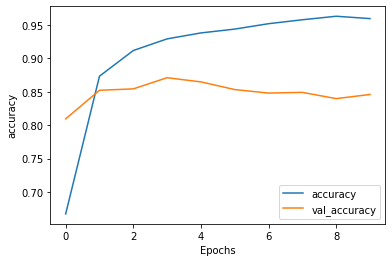

In [39]:
plot_graphs(history, 'accuracy')

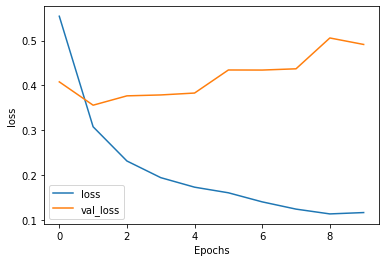

In [40]:
plot_graphs(history, 'loss')


# Stack two or more LSTM layers
Keras recurrent layers have two available modes that are controlled by the return_sequences constructor argument:

- Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape (batch_size, timesteps, output_features)).


- Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [44]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy']
             )

In [48]:
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/2
782/782 [==============================] - 1617s 2s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4979
Epoch 2/2
782/782 [==============================] - 1593s 2s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4979


In [49]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    782/Unknown - 339s 434ms/step - loss: 0.6931 - accuracy: 0.5000Test Loss: 0.6931462877851617
Test Accuracy: 0.5


In [50]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.10253756]]


In [51]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.10253756]]


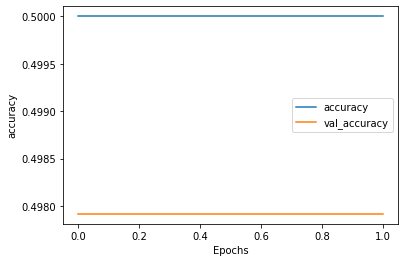

In [52]:
plot_graphs(history, 'accuracy')

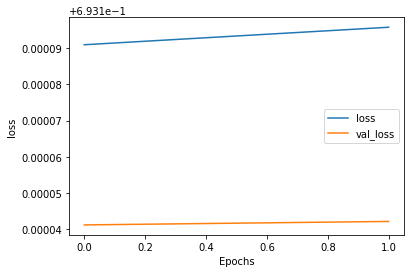

In [53]:
plot_graphs(history, 'loss')